In [1]:
import sys
import os
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import time

# Add the parent directory of AAC/ to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from PDAC.pdac_scheduling_ilp import solve_pdac_ilp
from PDAC.pdac_scheduling_lp import solve_pdac_lp
from PDAC.pdac_scheduling_greedy import solve_pdac_greedy
from PDAC.pdac_scheduling_naive import solve_pdac_naive

In [3]:
start_time = 0
end_time = 1400
max_length = 700

start_size = 10
end_size = 100
step_size = 10

analysis_num = 0

In [4]:
"""
Resources -> This is a list that keeps track of the amount of available resources at each time step

    - The resource curve information will be gathered from the Data/ folder.
"""
# Instantiate the resource curve
path = '../../Input_Data/solar_data.json'
with open(path, 'r') as file:
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

day = 3
resources = total[(24 * day) + start_time : (24 * day) + end_time]

# # Implement a resource curve scaling factor to better fit the jobs
scale_factor = 0.05
resources = [r * scale_factor for r in resources]

In [ ]:
# This is The list of job objects that will be scheduled
# They each have a release, deadline, duration and height
path = '../../Input_Data/job_data.json'
with open(path, 'r') as file:
    data = json.load(file)

# Randomly shuffle the jobs so that there is variation between trials
jobs_array = data['jobs']

pdac_inexact = []
pdac_exact = []
pdac_greedy = []
pdac_naive = []

final_data = []

for batch_size in range(start_size, end_size, step_size):
    exact_total = 0
    inexact_total = 0
    greedy_total = 0
    naive_total = 0
    
    print(f"\nBatch Size: {batch_size}")

    for trial in range(5):
        print(f"Trial #: {trial}")
        random.shuffle(jobs_array)
        
        start = time.time()
        exact = solve_pdac_ilp(jobs_array, resources, start_time, end_time, max_length, batch_size)
        exact_total += exact
        end = time.time()
        exact_time = end - start
        print(f"Exact Objective: {exact}, Elapsed Time: {exact_time}")

        start = time.time()
        inexact = solve_pdac_lp(jobs_array, resources, start_time, end_time, max_length, batch_size)
        inexact_total += inexact
        end = time.time()
        inexact_time = end - start
        print(f"Inexact Objective: {inexact}, Elapsed Time: {inexact_time}")

        start = time.time()
        greedy = solve_pdac_greedy(jobs_array, resources, start_time, end_time, max_length, batch_size)
        greedy_total += greedy
        end = time.time()
        greedy_time = end - start
        print(f"Greedy Objective: {greedy}, Elapsed Time: {greedy_time}")

        start = time.time()
        naive = solve_pdac_naive(jobs_array, resources, start_time, end_time, max_length, batch_size)
        naive_total += naive
        end = time.time()
        naive_time = end - start
        print(f"Naive Objective: {naive}, Elapsed Time: {naive_time}")

        trial_data = {"batch size": batch_size, "trial #": trial, "exact objective val": exact, "exact time": exact_time, "naive obective val": naive, "naive time": naive_time, "inexact objective val": inexact, "inexact time": inexact_time, "greedy objective val": greedy, "greedy time": greedy_time}
        final_data.append(trial_data)

    pdac_inexact.append(inexact_total / 5)
    pdac_exact.append(exact_total / 5)
    pdac_greedy.append(greedy_total / 5)
    pdac_naive.append(naive_total / 5)



Batch Size: 10
Trial #: 0
Exact Objective: 1958.5499999999995, Elapsed Time: 0.19352388381958008
Inexact Objective: 2014.0400000000002, Elapsed Time: 0.08311915397644043
Greedy Objective: 1973.6499999999999, Elapsed Time: 0.005676984786987305
Naive Objective: 1973.6499999999999, Elapsed Time: 0.00012969970703125
Trial #: 1
Exact Objective: 824.81, Elapsed Time: 0.2561788558959961
Inexact Objective: 1287.9199999999998, Elapsed Time: 0.06862473487854004
Greedy Objective: 1606.3099999999997, Elapsed Time: 0.005378007888793945
Naive Objective: 1502.26, Elapsed Time: 0.00012493133544921875
Trial #: 2
Exact Objective: 485.6399999999999, Elapsed Time: 0.10425996780395508
Inexact Objective: 1318.4499999999998, Elapsed Time: 0.03073406219482422
Greedy Objective: 1318.4499999999998, Elapsed Time: 0.0017421245574951172
Naive Objective: 1318.4499999999998, Elapsed Time: 0.00010275840759277344
Trial #: 3
Exact Objective: 1172.24, Elapsed Time: 0.2036442756652832
Inexact Objective: 1172.24, Elapsed

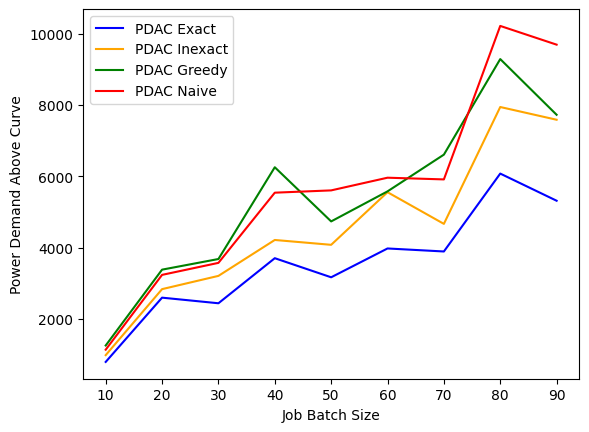

In [ ]:
job_graph_xvalues = np.array([i for i in range(start_size, end_size, step_size)])

plt.plot(job_graph_xvalues, pdac_exact, label="PDAC Exact", color='blue')
plt.plot(job_graph_xvalues, pdac_inexact, label="PDAC Inexact", color='orange')
plt.plot(job_graph_xvalues, pdac_greedy, label="PDAC Greedy", color='green')
plt.plot(job_graph_xvalues, pdac_naive, label="PDAC Naive", color='red')


plt.xlabel("Job Batch Size")
plt.ylabel("Power Demand Above Curve")
plt.legend()
plt.show()

In [ ]:
import csv
# Write to a data csv file
with open(f"../../Output_Data/PDAC_Results/exact_pdac_analysis_{analysis_num}.csv", "a", newline="") as csvfile:
    fieldnames = ['batch size', 'trial #', 'exact objective val', 'exact time', 'naive obective val', 'naive time', 'inexact objective val', 'inexact time', 'greedy objective val', 'greedy time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Only write the header on the very first trial run
    writer.writeheader()
    writer.writerows(final_data)

    csvfile.close()